<a href="https://colab.research.google.com/github/MatheusABomfim/Mest_MBL2_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading data and packages**

**Packages install**

In [2]:
# Install shap
!pip install shap

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [66 lines of output]
      Partial import of sklearn during the build process.
      setup.py:128: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.command.build_ext import build_ext  # noqa
      INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      Traceback (most recent call last):
        File "c:\Users\mathe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces

   ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 107.7/107.7 kB 1.5 MB/s eta 0:00:00


**Libraries import**

In [218]:
# Import necessary libraries and packages
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.inspection import permutation_importance

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,
    learning_curve
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, accuracy_score, roc_curve, auc, make_scorer,
    precision_score, f1_score
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,
    RobustScaler, StandardScaler
)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

# imbalanced-learn imports
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# joblib imports
from joblib import dump, load

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# openpyxl imports
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# ipywidgets imports
from ipywidgets import interact, widgets

# shap imports
import shap
from sklearn.inspection import permutation_importance

# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**Data import**

In [219]:
# Path to the CSV file containing the DataFrame
combined_data_file = '..\\datasets\\df_combined.csv'

# Loading the DataFrame directly from the CSV file
df_combined = pd.read_csv(combined_data_file)

# Normalizando apenas a coluna "Idade"
scaler = MinMaxScaler()
df_combined['Idade'] = scaler.fit_transform(df_combined[['Idade']])

y = df_combined['HAM/TSP']  # Target variable
X = df_combined.drop('HAM/TSP', axis=1)  # Predictor variables

# Exibindo as primeiras linhas do DataFrame com a coluna "Idade" normalizada
display(df_combined.head())

,Sexo,Idade,MBL-550,MBL -221,MBL EXON,Sintomas urinários,Dor,Transtorno/sintomas neurológicos,HAM/TSP
0,0,0.758621,1,0,2,2,4,5,0
1,1,0.137931,0,0,1,0,0,0,0
2,0,0.517241,2,1,0,0,0,0,0
3,0,0.206897,1,0,0,0,0,0,0
4,0,0.293103,1,1,1,0,0,0,0


In [220]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AdaBoost', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)
definite_name = ['Decision Tree', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron', 'Naive Bayes', 'Random Forest', 'Support Vector Machine', 'K-Nearest Neighbors', 'AdaBoost', 'Linear SVM']


Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AdaBoost carregado com sucesso.
Modelo LSVM carregado com sucesso.


**Load the definitions identified for the models**

In [4]:
X.columns

Index(['Sexo', 'Idade', 'MBL-550', 'MBL -221', 'MBL EXON',
       'Sintomas urinários', 'Dor', 'Transtorno/sintomas neurológicos'],
      dtype='object')

**Pre-processing**

In [225]:
# Instantiating RandomUnderSampler
rus = RandomUnderSampler()

# Apply RandomUnderSampler to data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame with the resampled data
df_ = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['HAM/TSP'])], axis=1)

# ...

y = df_['HAM/TSP'].to_numpy()  # Target variable as a NumPy array
X = df_.drop('HAM/TSP', axis=1).to_numpy()  # Predictor variables as a NumPy array

**SHAP execution and plots**

# Waterfall

Importância das Características do modelo Decision Tree


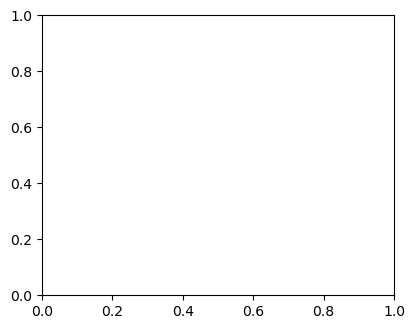

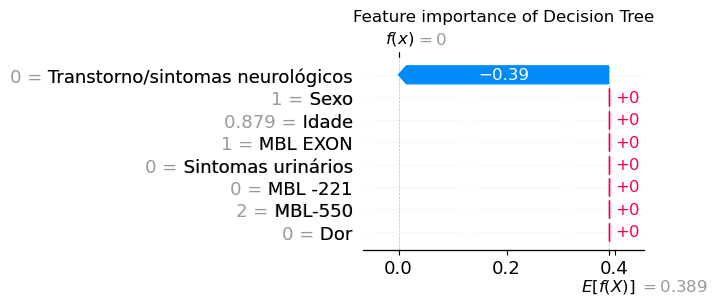

Importância das Características do modelo Gradient Boosting


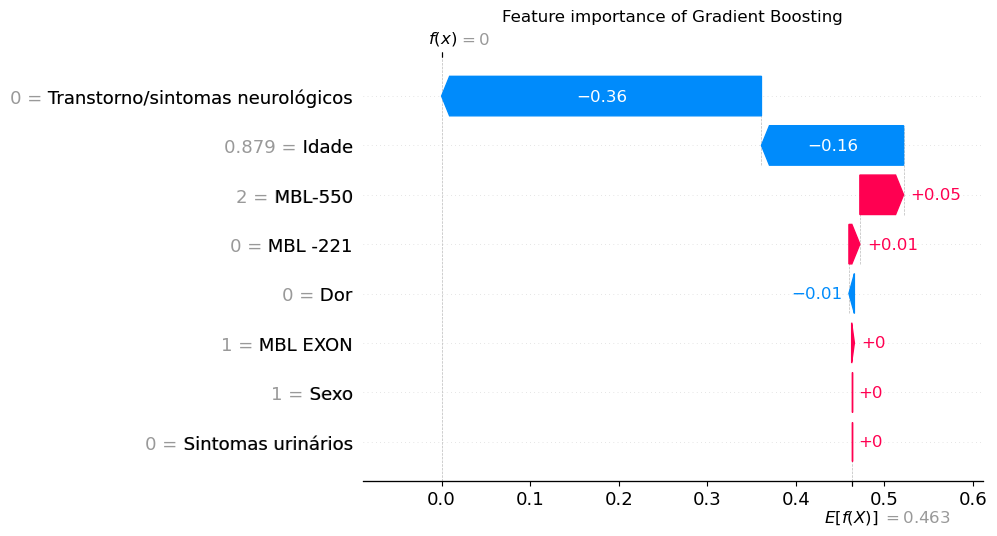

Importância das Características do modelo Logistic Regression


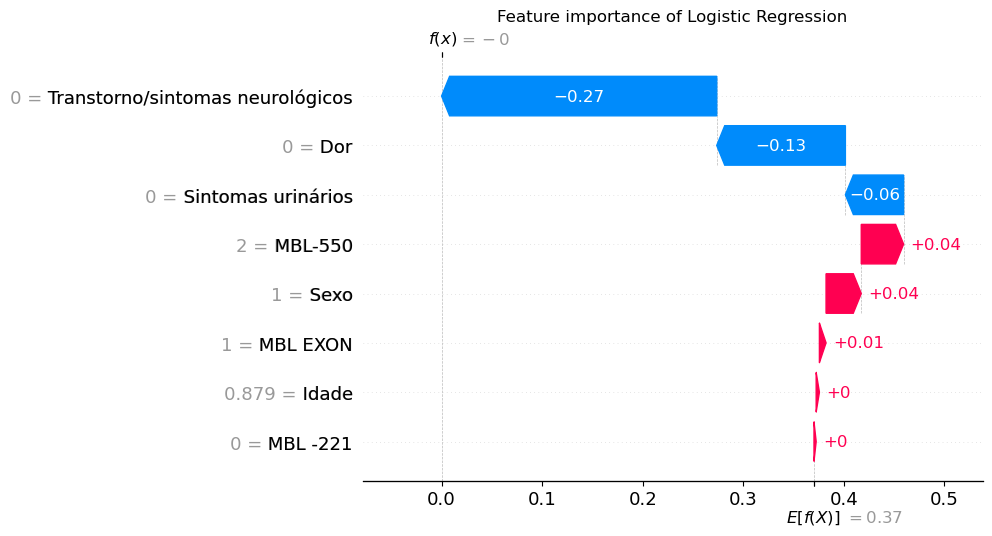

Importância das Características do modelo Multi-layer Perceptron


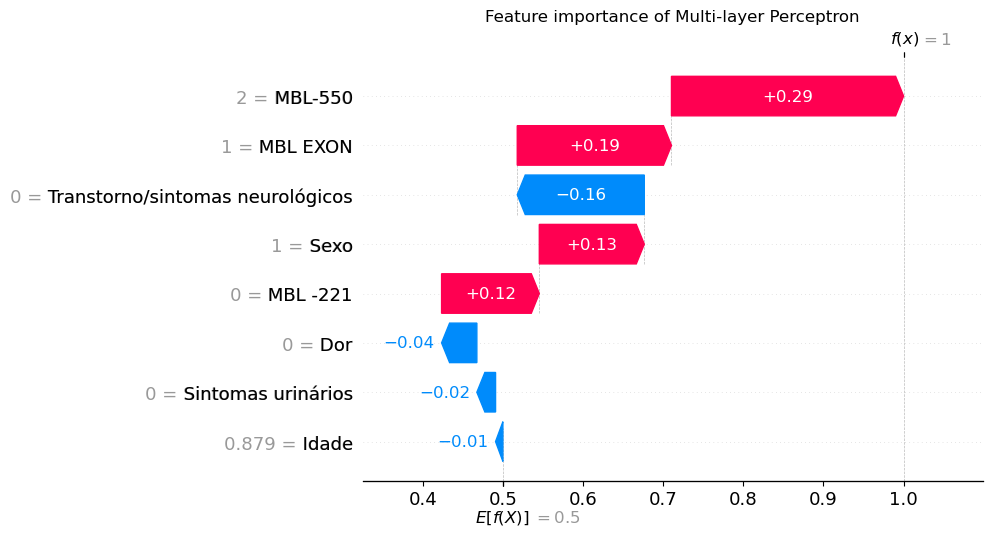

Importância das Características do modelo Naive Bayes


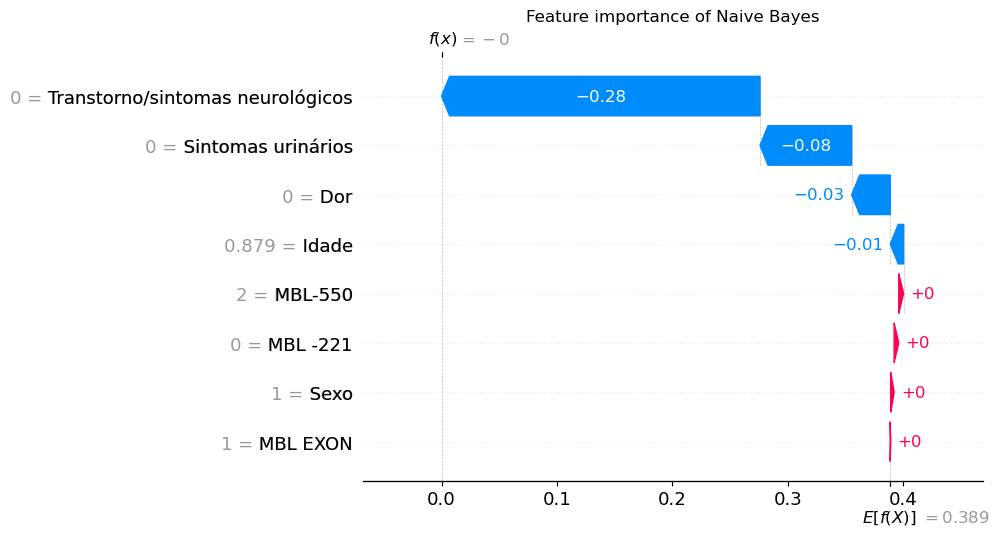

Importância das Características do modelo Random Forest


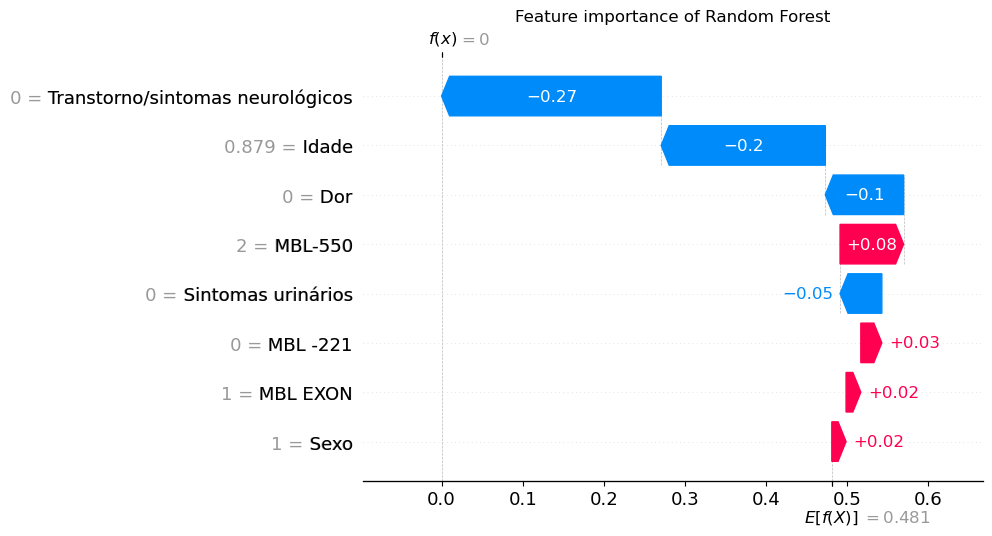

Importância das Características do modelo Support Vector Machine


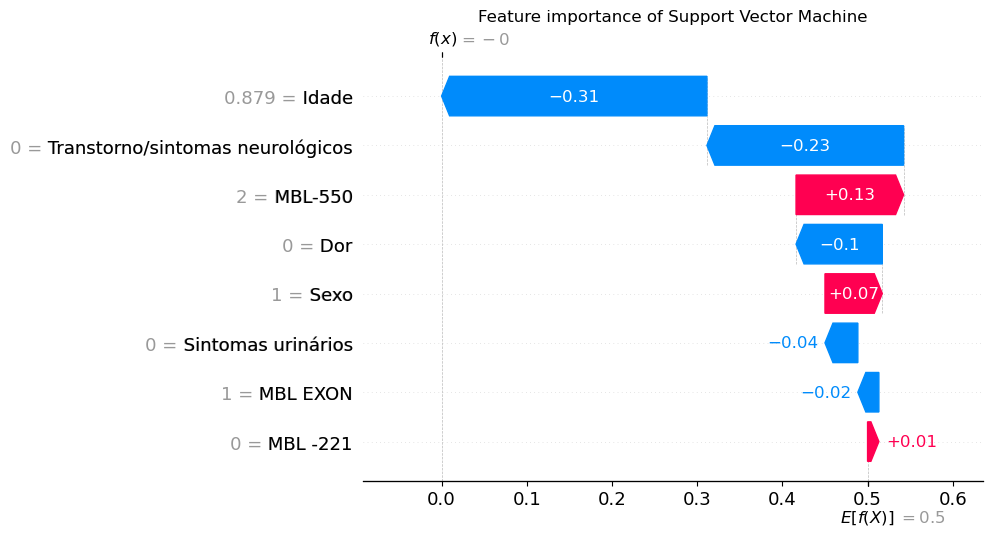

ExactExplainer explainer: 55it [00:15,  1.19it/s]                        


Importância das Características do modelo K-Nearest Neighbors


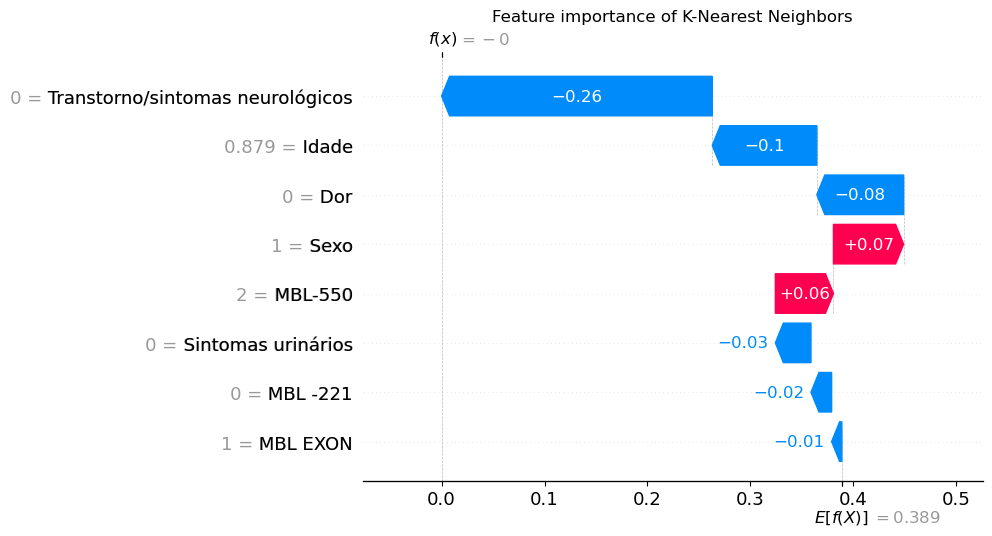

ExactExplainer explainer: 55it [00:14,  1.04it/s]                        


Importância das Características do modelo AdaBoost


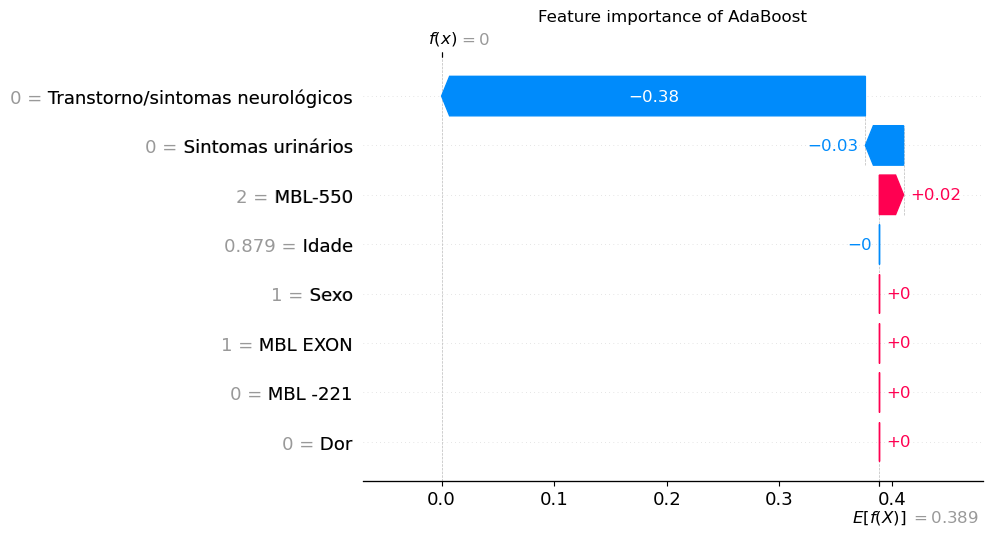

Importância das Características do modelo Linear SVM


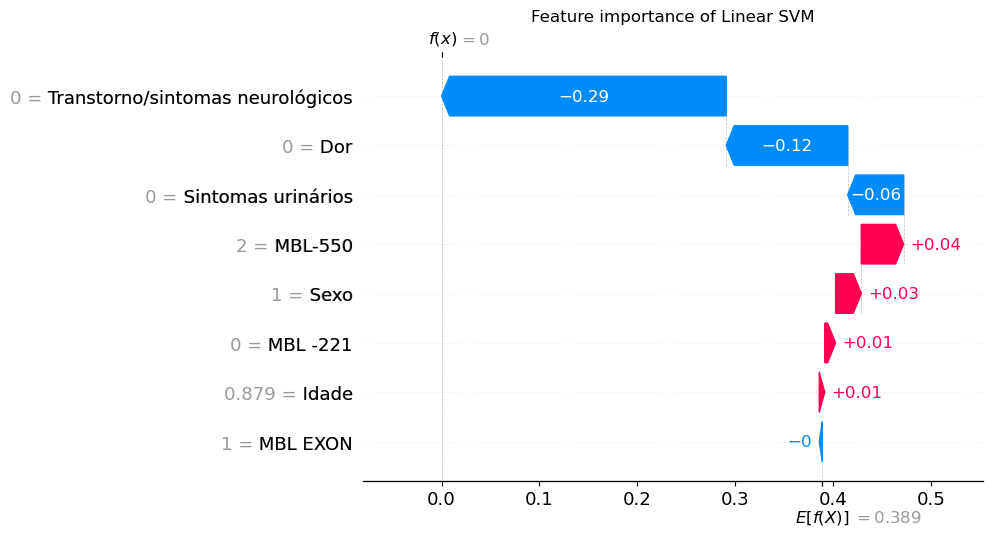

In [187]:
# Training the classifiers
for model_name, item in classifiers.items():
    # Training model
    item.fit(X, y)

    # Fits the explainer
    explainer = shap.Explainer(item.predict, X)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X)

    # Get the corresponding full name from definite_name
    full_name = definite_name[model_names.index(model_name)]

    print(f'Importância das Características do modelo {full_name}')
    shap.plots.waterfall(shap_values[0], show=False)
    
    # Set the title with the full model name
    plt.title(f'Feature importance of {full_name}')
    plt.show()


   

# Forceplot + Scatterplot

Importância das Características do modelo DT


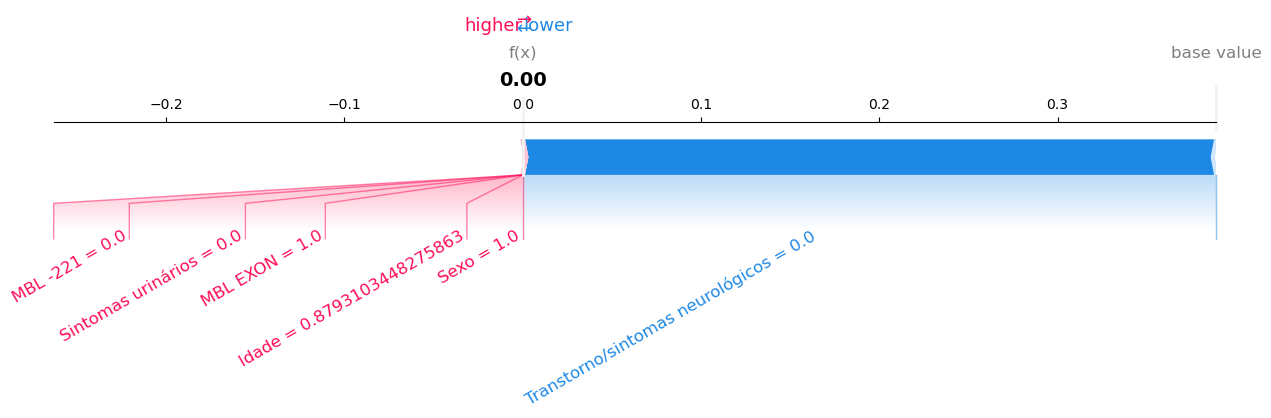

Versão detalhada:


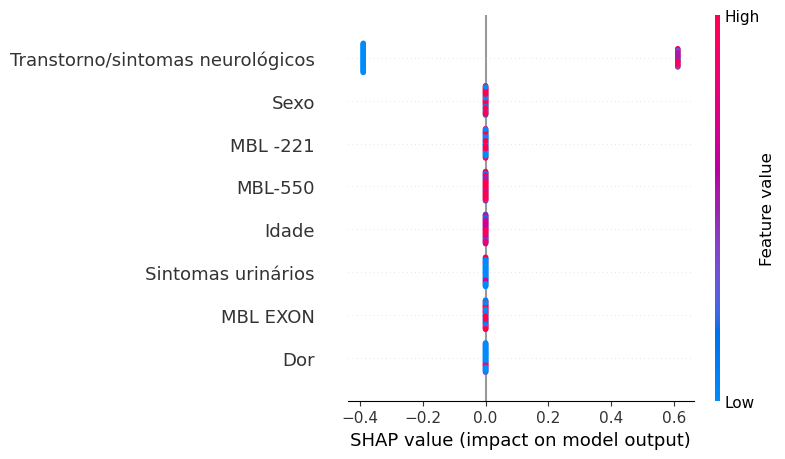

Importância das Características do modelo GB


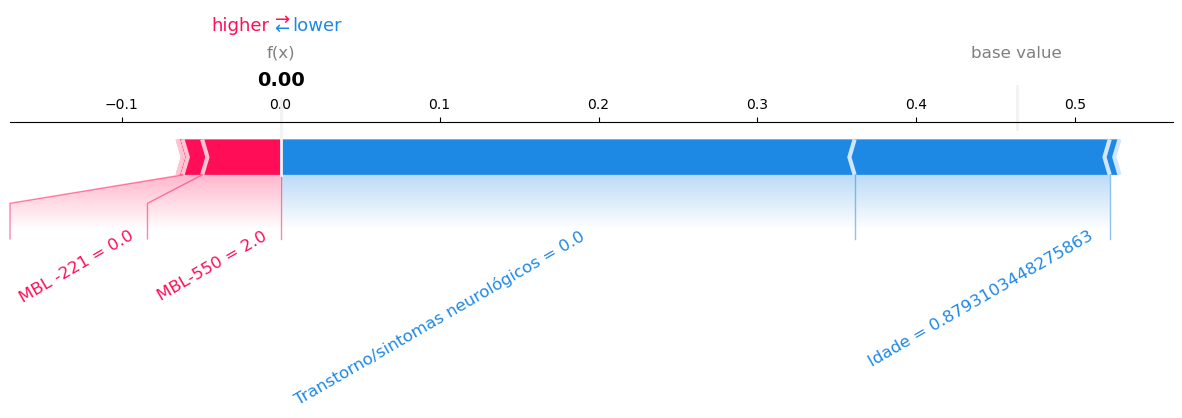

Versão detalhada:


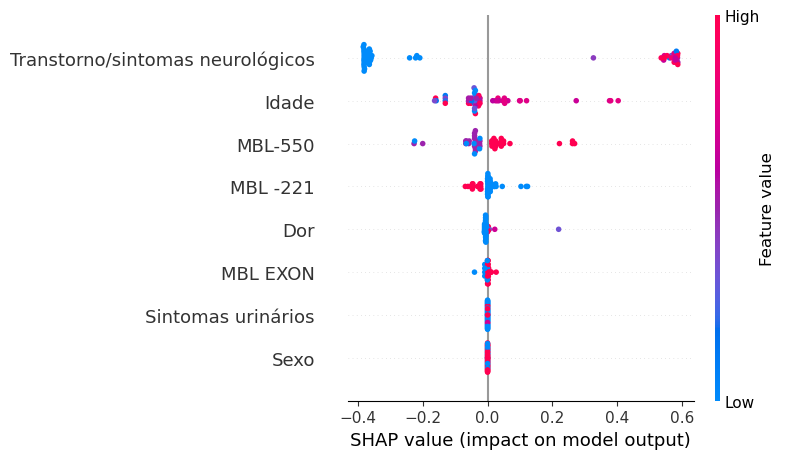

Importância das Características do modelo LR


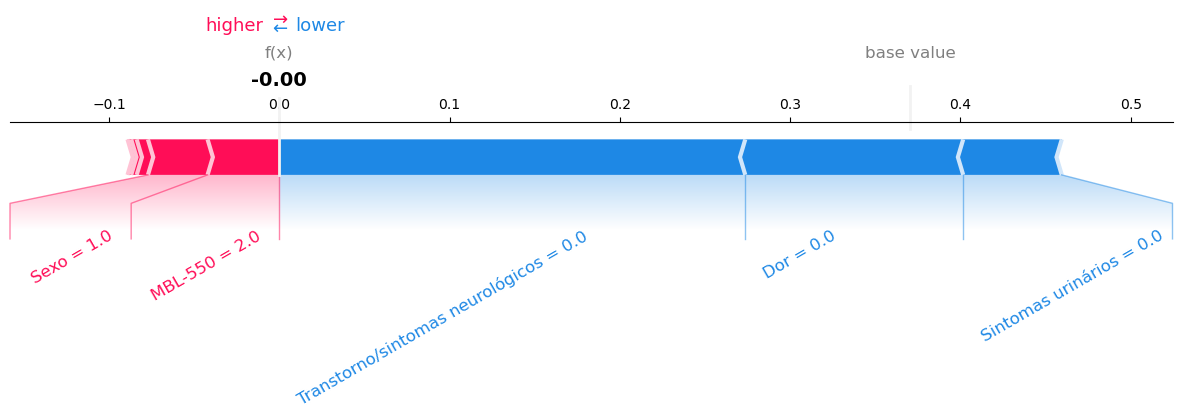

Versão detalhada:


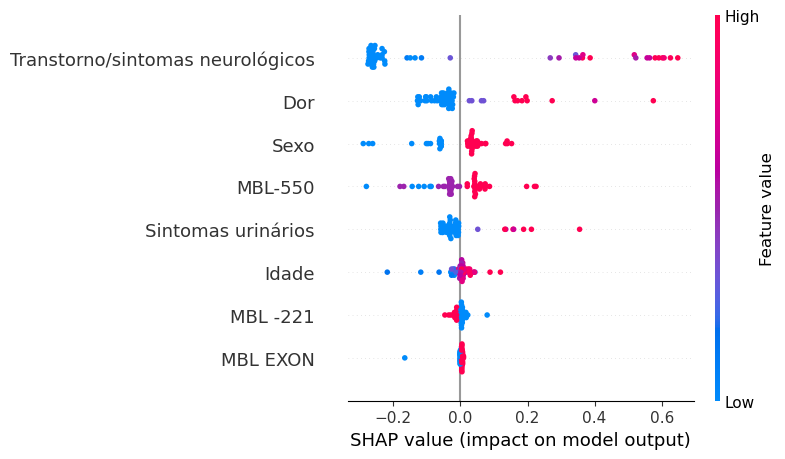

Importância das Características do modelo MLP


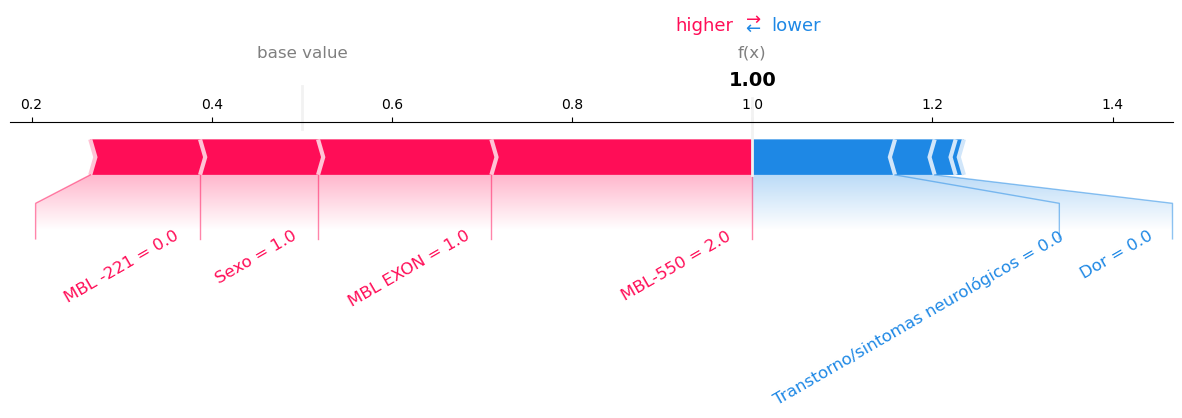

Versão detalhada:


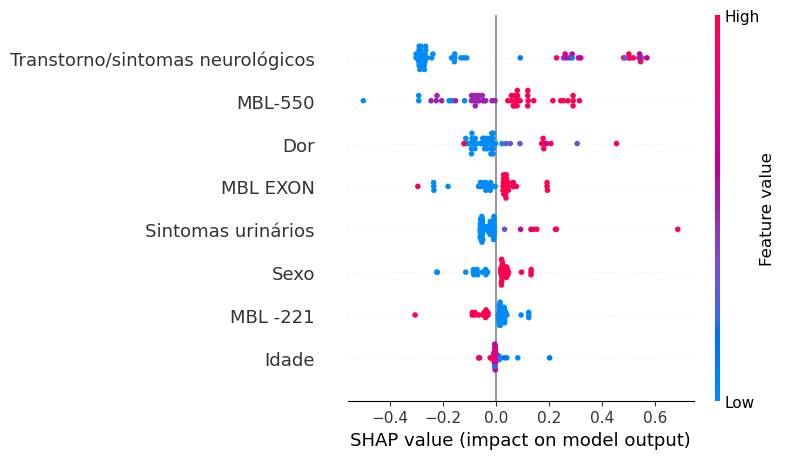

Importância das Características do modelo NB


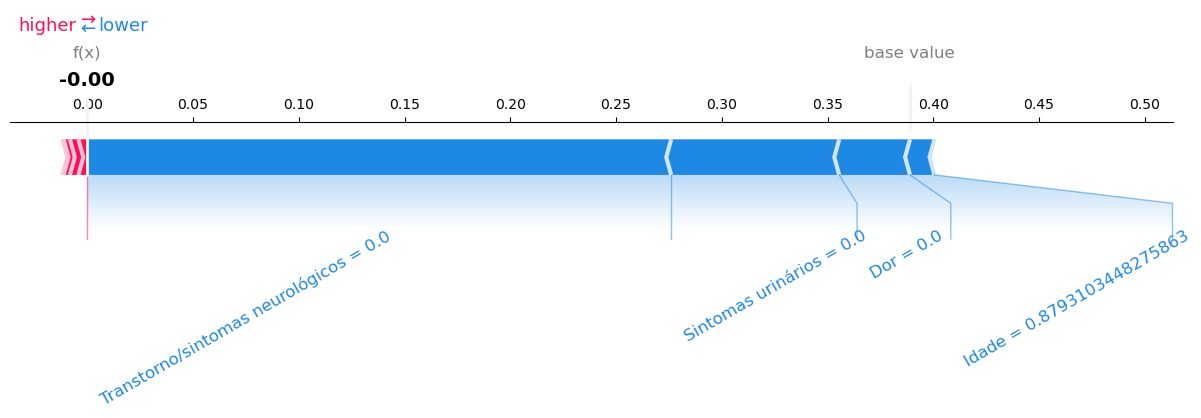

Versão detalhada:


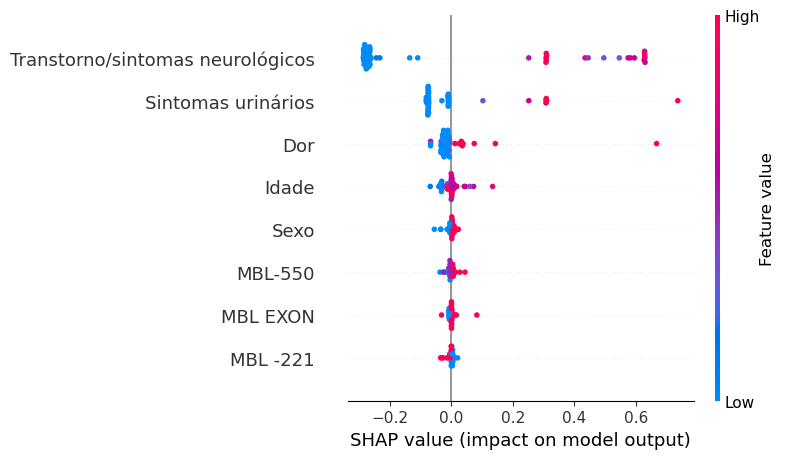

Importância das Características do modelo RF


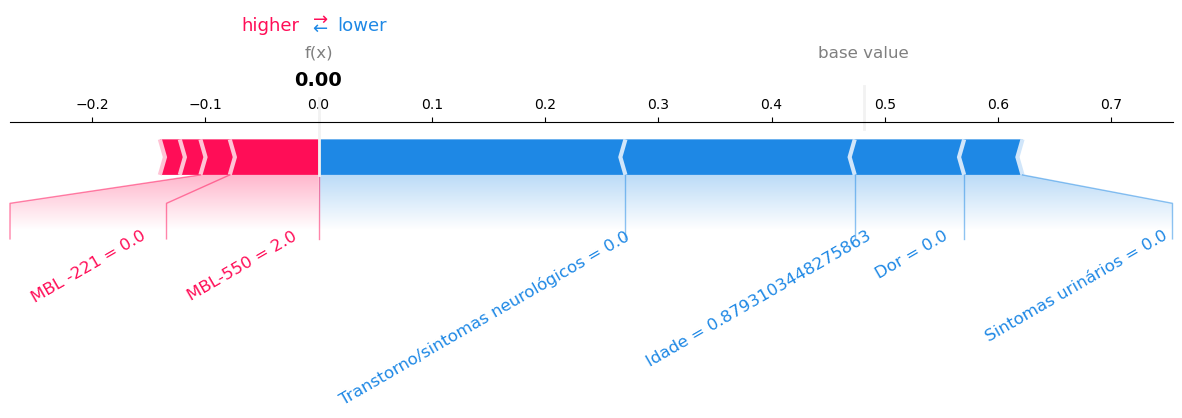

Versão detalhada:


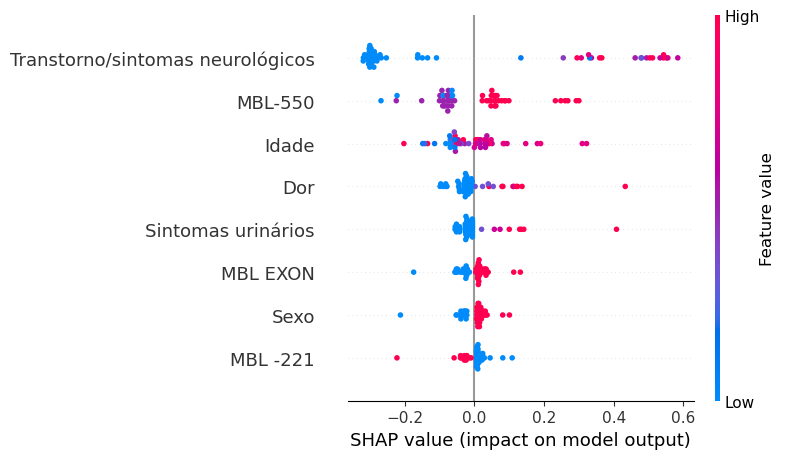

Importância das Características do modelo SVM


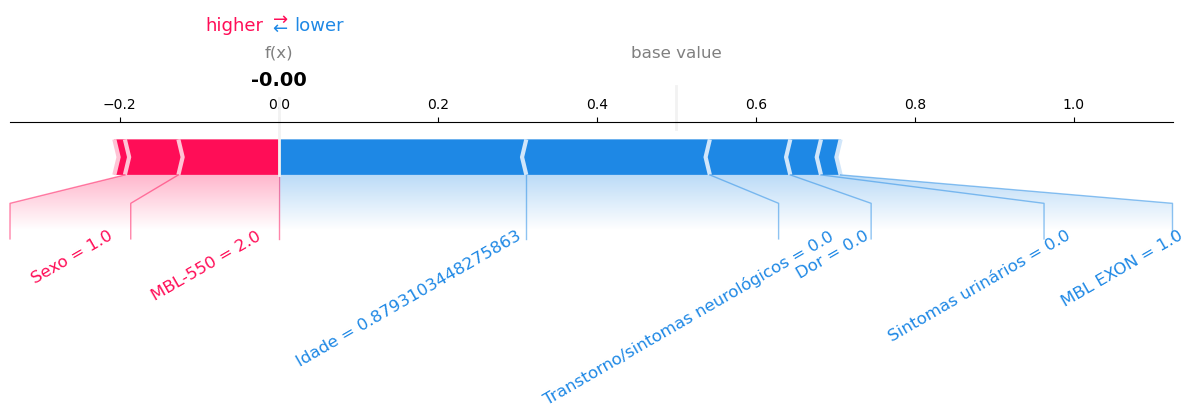

Versão detalhada:


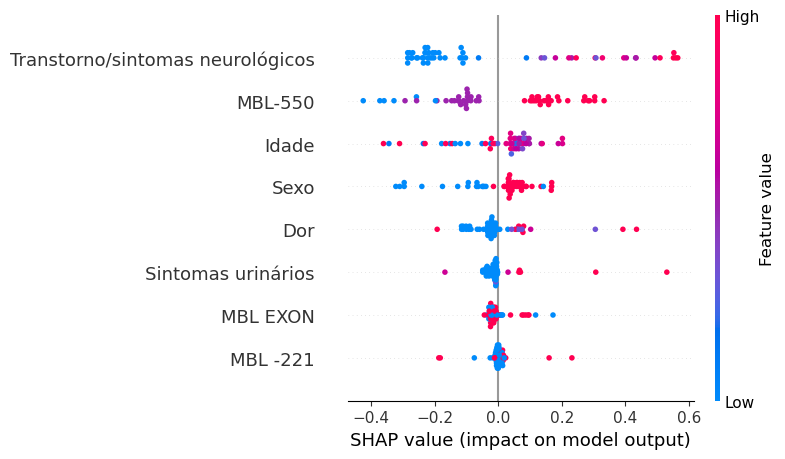

ExactExplainer explainer: 55it [00:13,  1.20s/it]                        


Importância das Características do modelo KNN


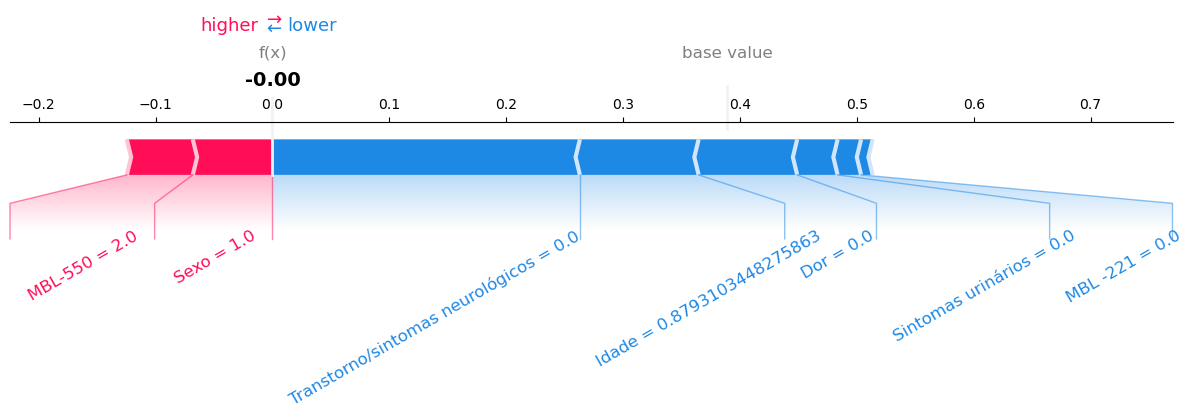

Versão detalhada:


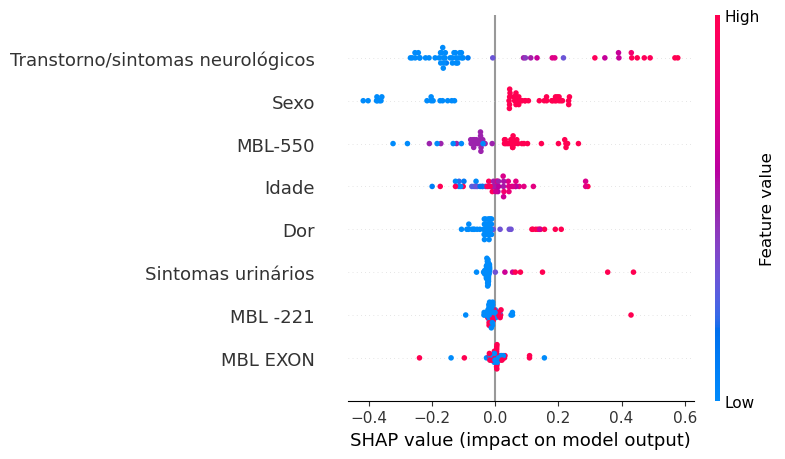

ExactExplainer explainer: 55it [00:14,  1.09s/it]                        


Importância das Características do modelo AdaBoost


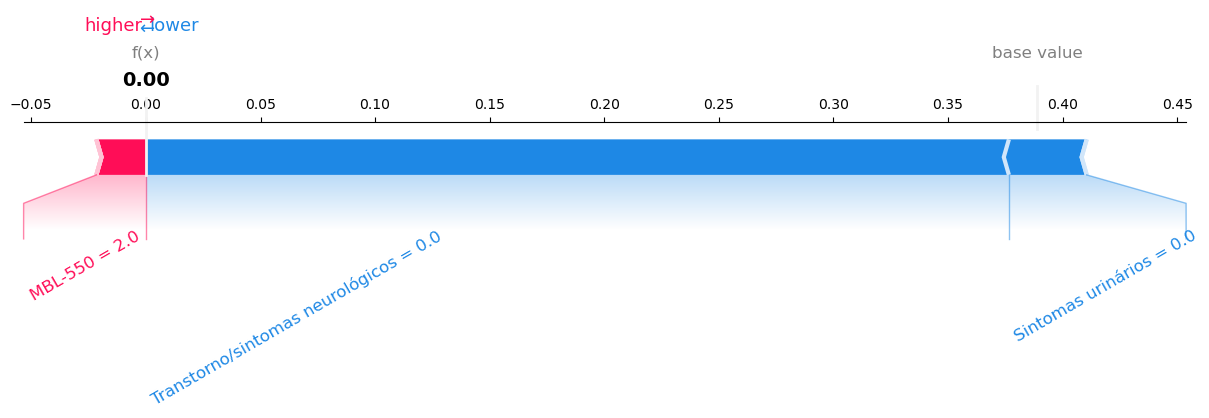

Versão detalhada:


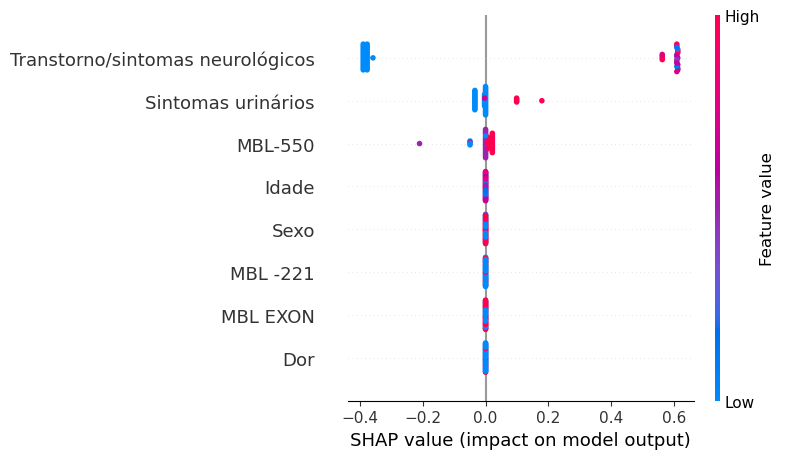

Importância das Características do modelo LSVM


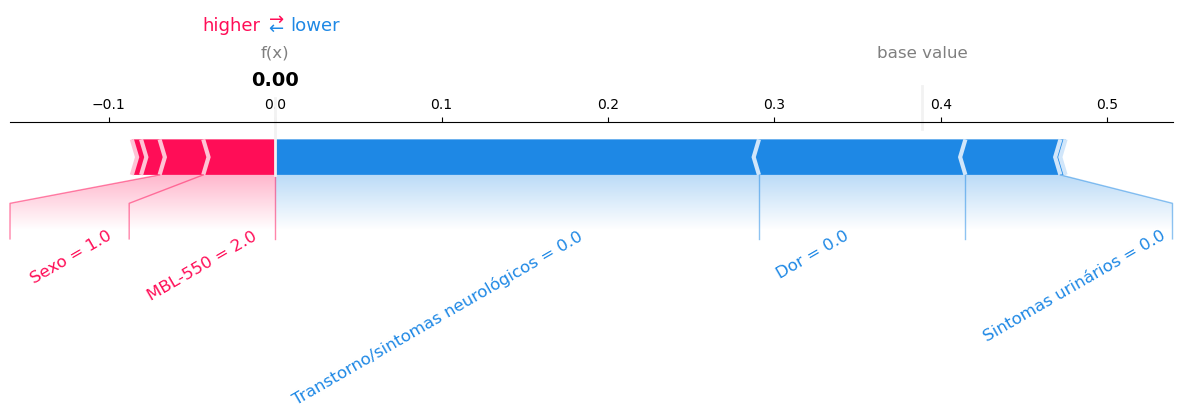

Versão detalhada:


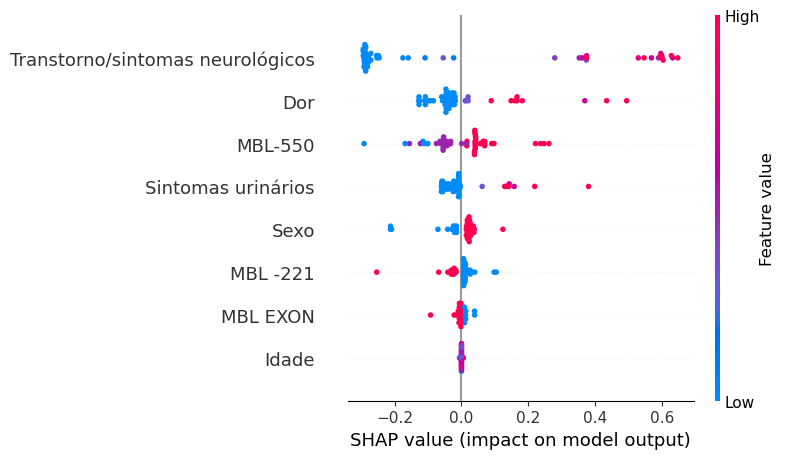

In [188]:
for model_name, item in classifiers.items():
    # Treinamento do modelo
    item.fit(X, y)

    # Ajusta o explicador
    explainer = shap.Explainer(item.predict, X)
    # Calcula os valores SHAP - Isso pode demorar
    shap_values = explainer(X)

    print(f'Importância das Características do modelo {model_name}')
    for i in range(len(X)):
        # Visualiza o force plot para a primeira amostra
        shap.plots.force(shap_values[0], matplotlib=True, show=True, figsize=(15, 3), 
                         text_rotation=30)
        plt.show()
        break  # Remove ou ajuste este break para ver mais plots

    # Para visualização resumida
    print("Versão detalhada:")
    shap.summary_plot(shap_values, X)
    plt.show()

In [199]:
print(X)

     Sexo     Idade  MBL-550  MBL -221  MBL EXON  Sintomas urinários  Dor  \
105     1  0.879310        2         0         1                   0    0   
88      1  0.327586        1         0         1                   0    0   
57      0  0.637931        1         1         1                   0    0   
40      0  0.517241        1         0         0                   0    0   
8       1  0.655172        0         0         1                   0    0   
145     1  0.362069        0         0         1                   0    3   
93      0  0.206897        1         0         1                   0    0   
90      1  0.620690        1         0         1                   0    0   
22      1  0.844828        2         1         0                   0    0   
107     1  0.000000        1         0         0                   0    0   
92      0  0.120690        1         0         1                   0    0   
53      0  0.413793        2         0         0                   0    0   

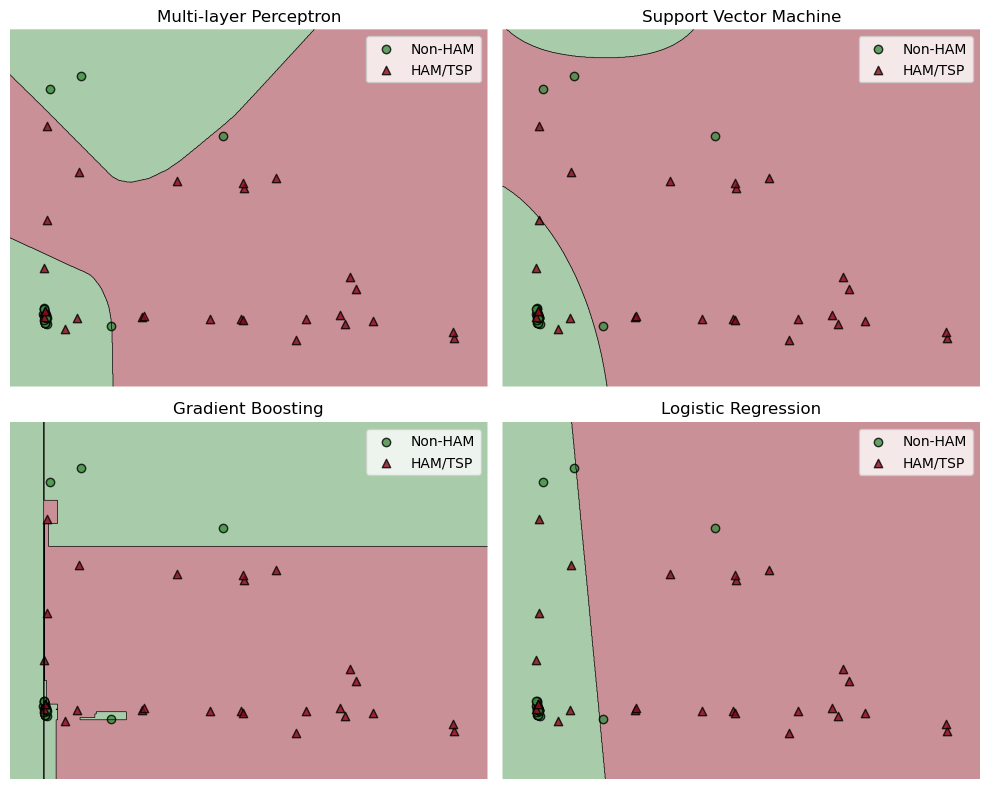

In [238]:
import numpy as np
from mlxtend.plotting import plot_decision_regions 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# ... (rest of the code remains the same)

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Define the classifiers
classifiers = {
    'MLP': MLPClassifier(),
    'SVM': SVC(),
    'GB': GradientBoostingClassifier(),
    'LR': LogisticRegression()
}

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

# Define the colors
colors = ['#3E8E41', '#8B0A1A']  # Sage Green and Deep Red

for model_name, grd in zip(top_model_names, itertools.product([0, 1], repeat=2)):
    clf = classifiers[model_name]
    clf.fit(X_pca, y)  # Fit the classifier to the PCA-transformed data
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X_pca, y, clf=clf, markers=['o', '^'], 
                          colors=','.join(colors))  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_title(model_names_full[model_name])  
    ax.legend(['Non-HAM', 'HAM/TSP'])  # Add this line to customize the legend labels

plt.tight_layout()
plt.show()

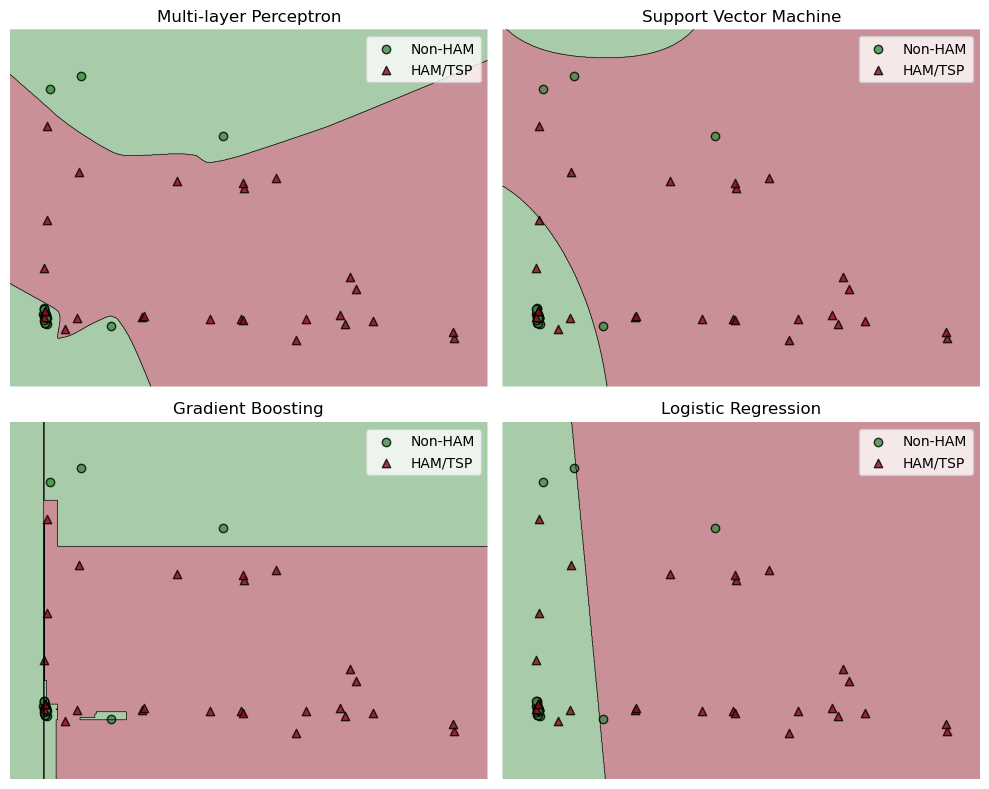

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Mapeamento dos nomes curtos para nomes completos dos modelos
model_names_full = {
    'MLP': 'Multi-layer Perceptron',
    'SVM': 'Support Vector Machine',
    'GB': 'Gradient Boosting',
    'LR': 'Logistic Regression'
}

# Lista dos nomes dos modelos principais
top_model_names = ['MLP', 'SVM', 'GB', 'LR']

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Define the classifiers
classifiers = {
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, learning_rate='adaptive', solver='adam'),
    'SVM': SVC(),
    'GB': GradientBoostingClassifier(),
    'LR': LogisticRegression()
}

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

# Define the colors
colors = ['#3E8E41', '#8B0A1A']  # Sage Green and Deep Red

for model_name, grd in zip(top_model_names, itertools.product([0, 1], repeat=2)):
    clf = classifiers[model_name]
    clf.fit(X_pca, y)  # Fit the classifier to the PCA-transformed data
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X_pca, y, clf=clf, markers=['o', '^'], 
                          colors=','.join(colors))  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_title(model_names_full[model_name])  
    ax.legend(['Non-HAM', 'HAM/TSP'])  # Add this line to customize the legend labels

plt.tight_layout()
plt.show()

In [241]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your pandas DataFrame

# Select the first group of features
group1_features = ['Sexo', 'Idade', 'Sintomas urinários', 'Dor', 'Transtorno/sintomas neurológicos']
X_group1 = X[group1_features]

# Apply PCA to the first group of features
pca_group1 = PCA(n_components=2)
X_pca_group1 = pca_group1.fit_transform(X_group1)

# Select the second group of features
group2_features = ['MBL-550', 'MBL -221', 'MBL EXON']
X_group2 = X[group2_features]

# Apply PCA to the second group of features
pca_group2 = PCA(n_components=2)
X_pca_group2 = pca_group2.fit_transform(X_group2)

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define the classifiers
clf1 = LogisticRegression(random_state=1, solver='newton-cg', multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

# Plot the decision regions for each classifier using the first group of features
for clf, ax, label in zip([clf1, clf2, clf3, clf4], axs.flatten(), ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']):
    clf.fit(X_pca_group1, y)
    plot_decision_regions(X_pca_group1, y, clf=clf, ax=ax, legend=2)
    ax.set_title(label)

plt.show()

# Create a new figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the decision regions for each classifier using the second group of features
for clf, ax, label in zip([clf1, clf2, clf3, clf4], axs.flatten(), ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']):
    clf.fit(X_pca_group2, y)
    plot_decision_regions(X_pca_group2, y, clf=clf, ax=ax, legend=2)
    ax.set_title(label)

plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices